# Day 4 notebook

## Solution for Day 3 assignment from Monday, Sept. 21

In [28]:
#get 10 files, each is the same timestep for a member of a
#10 member ensemble
data_download=False
if data_download:
    root='http://clouds.eos.ubc.ca/~phil/docs/atsc500/dryles'
    for i in np.arange(1,11,dtype=np.int):
        the_name='mar12014_{:d}_15600.nc'.format(i)
        print(the_name)
        url='{}/{}'.format(root,the_name)
        urllib.request.urlretrieve(url,the_name)
           

1. Hand in a notebook that

   1. plots the ensemble average theta profile for 1 column, and the ensemble averaged vertical heat flux
      in Watts/m^2 through the bottom model layer.
      
   1. histogram the normalized pressure perturbation $p^\prime/p(z)$ for 1 ensemble member
   
2. Read the rest of Stull chapter 2 and do problem 8 if you haven't already

In [11]:
import numpy as np
from matplotlib import pyplot as plt
from netCDF4 import Dataset
import glob

#
# use this function to sort filenames in numerical order
#
def sort_name(name):
    #
    # filename looks like mar12014_10_15600.nc
    # so line below produces number='10'
    #
    front, number, back = name.split('_')
    return int(number)

In [12]:
def theta(p, T):
    """
      input: p (Pa), scalar pressure
             T (K),  scalar or array of temperatures
      output: thetaval (K) potential temperature
    """
    Rd = 287  # dry air gas constant  J/kg/K
    cp = 1004.  # dry air heat capacity at constant pressure (J/kg/K)
    p0 = 1.e5  # reference pressure (Pa)
    the_exp = Rd / cp
    thetaval = T * (p0 / p)**the_exp
    return thetaval

1. Gather all 10 filenames and save them to a list, reading out z and p from
   the first file, since these are the same in all 10 members

In [13]:
the_files = glob.glob('mar*nc')
print(the_files)
the_files.sort(key=sort_name)
save_nc = []
for count, filename in enumerate(the_files):
    save_nc.append(Dataset(filename, 'r'))
z = save_nc[0].variables['z'][...]
p = save_nc[0].variables['p'][...] * 100.

['mar12014_10_15600.nc', 'mar12014_1_15600.nc', 'mar12014_2_15600.nc', 'mar12014_3_15600.nc', 'mar12014_4_15600.nc', 'mar12014_5_15600.nc', 'mar12014_6_15600.nc', 'mar12014_7_15600.nc', 'mar12014_8_15600.nc', 'mar12014_9_15600.nc']


2\. read the temperature ffrom one cell for all 10 files, calculate the $\theta$ and
    average the 10 together

In [14]:
#
# first find the average theta profile for one cell
#
xcoord, ycoord = (20, 40)
theta_accum = np.zeros_like(z)
for the_nc in save_nc:
    the_temps = the_nc.variables['TABS'][0, :, ycoord, xcoord]
    theta_vals = []
    for the_p, the_temp in zip(p, the_temps):
        theta_vals.append(theta(the_p, the_temp))
    theta_vals = np.array(theta_vals)
    theta_accum += theta_vals
theta_avg = theta_accum / len(save_nc)

## Q1 answer: plot of $\langle \theta(z) \rangle$

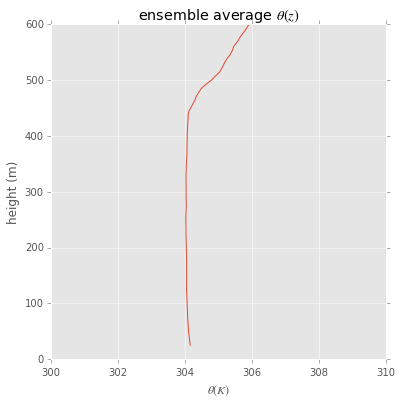

In [27]:
%matplotlib inline
plt.style.use('ggplotb')
fig, ax = plt.subplots(1, 1,figsize=(6,6))
ax.plot(theta_avg, z)
ax.set(ylim=(0, 600), xlim=(300, 310))
out=ax.set(title=r'ensemble average $\theta(z)$',xlabel=r'$\theta (K)$',
       ylabel='height (m)')

## Q2 answer: vertical heat flux at z=200 m

In [31]:
#
# now find the average heat flux through z[7] = 200 meters
#
flux = 0
for the_nc in save_nc:
    the_temps = the_nc.variables['TABS'][0, 7, :, :]
    the_w = the_nc.variables['W'][0, 7, :, :]
    T_bar = the_temps.mean()
    W_bar = the_w.mean()
    T_prime = the_temps - T_bar
    W_prime = the_w - W_bar
    flux += (T_prime * W_prime).mean()
flux = flux / len(save_nc)
Rd = 287.  # J/kg/K
cp = 1004.  # J/kg/K
rho = p[7] / (Rd * T_bar)
flux = rho * cp * flux
#
# show how to use a dictionary and format_map to place
# values in a string template
#
answer="""
    Q2 answer:  the heat flux at {height} is {flux:5.2f} W/m^2
"""
values=dict(height=z[7],flux=flux)
print(answer.format_map(values))


    Q2 answer:  the heat flux at 200.0 is 29.90 W/m^2



## Q3 answer: normalized pressure perturbation
(range is $-7 \times 10^{-6} \rightarrow +7 \times 10^{-6}$ )

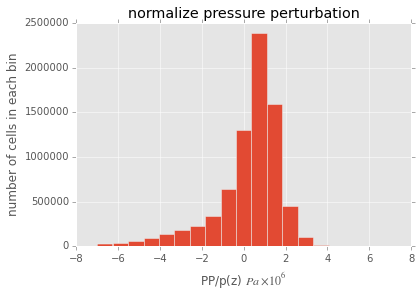

In [37]:
#
# histogram the normailzed pressure perturbation for one ensemble member
#
the_pp = save_nc[0].variables['PP'][0, :, :, :]
for index,the_pres in enumerate(p):
    the_pp[index,:,:]=the_pp[index,:,:]/p[index]

fig, ax = plt.subplots(1, 1)
ax.hist((the_pp*1.e6).flat,bins=linspace(-7,7,20))
out=ax.set(title='normalize pressure perturbation',xlabel=r'PP/p(z) $\times 10^6$',
       ylabel='number of cells in each bin')
        

## Stull problem 8

enthaply flux through bottom of layer:  

In [38]:
cpd=1004.
rho=1
h_flux_bot=rho*0.2*cpd
h_flux_top=rho*0.1*cpd
net_heating=h_flux_bot-h_flux_top  #W/m^2
delta_z=200  #meters
total_mass=rho*delta_z  #kg/m^2
dT_dt=net_heating/(total_mass*cpd)*3600 #K/hour  
print('net heating is {:5.1f} K/hour'.format(dT_dt))

net heating is   1.8 K/hour
